# Modeling and forecasting of twitter volume timeseries
After understanding our data in the previous section, [descriptive statistics](./descriptive_statistics.ipynb), we now want to quickly run a time-series forecast using [gluonts](https://github.com/awslabs/gluon-ts).
In this example we use the same dataset as before and apply two separate models, [DeepAR](https://arxiv.org/abs/1704.04110) and a simple multi-layer perceptron. At the end we shall compare the results of the evaluation of both models.

After that we will use SageMaker to perform hyperparamter tuning to find the best set of hyperparameters for our model. To do so we will define an MXNet estimator and provide an entry point file, that defines the model and training. The default MXNet docker image does not come with GluonTS, so in the 3rd part this notebook you will learn how to build your custom container.

In [1]:
import pandas as pd
import gluonts
import numpy as np
import matplotlib.pyplot as plt
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.dataset.common import ListDataset
from gluonts.trainer import Trainer
import pathlib
import json
import boto3
import s3fs
import csv

INFO:root:Using CPU
INFO:root:Using CPU


### Settingup hyperparameters
Here we just set the number of epochs and rely on default values for the rest of the parameters in order to make the example more understandable.

In [2]:
EPOCHS = 20

### Loading the data

In [6]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"

In [4]:
df = pd.read_csv(filepath_or_buffer=url, header=0, index_col=0)
df.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


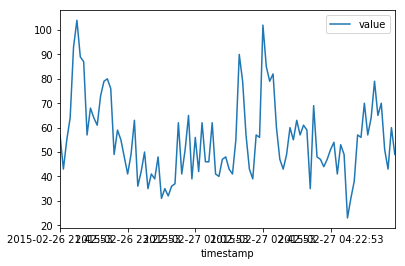

In [5]:
df[:100].plot()

### Plotting forecast helper function
Often it is interesting to tune or evaluate the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

The below function plots a forecast for a given data and a given predictor. Let's dive deeper into components of this funciton.
`from gluonts.model` includes a number of implemented models models. Each model has an estimator. An estimator accepts a series of model and hyperparameters. Parameters include a trainer that accepts optimization parameters. The estimator also accepts parameters such as context, number of layers, context length, time-series frequency, and prediction length amongst others.
The estimator has a `train` method that is used for fitting the data. The `train` method retuns a predictor that can be used to forecast based on input data.

`plot_forecast` function accepts a `predictor` object and an iterable dataset to plot the data and the forecast.

The centerpiece of the forecast function is `forecast.plot`. It plots the forecast in different confidence intervals

In [6]:
def plot_forecast(predictor, test_data):
    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
        to_pandas(test_entry)[-60:].plot(linewidth=2)
        forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
    plt.grid(which='both')

### Dataset
`gluonts.dataset.common` has a class `ListDataset`. GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Timestamp`. 

In this example we are using a `gluonts.dataset.common.ListDataset`. A `ListDataset` consist of a list of of dictionaries with the following format:
```
{'start': Timestamp('2019-07-26 00:00:00', freq='D'),
  'cat': [5, 4, 42, 17, 0, 0, 0],
  'target': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0.], dtype=float32)},
 {'start': Timestamp('2019-07-26 00:00:00', freq='D'),
  'cat': [8, 7, 32, 13, 0, 0, 0],
  'target': array([4., 3., 5., 2., 5., 2., 3., 7., 4., 3., 3., 2.], dtype=float32)}
```
Each dictionary contains one timeseries and we need to pass *start* as `pandas.index` and a *target* as an iterable set of timestamp values from our pandas dataframe. We can also indicate categorical features in the field `cat`.

In the followng cell we build a training dataset ending at April 5th, 2015 and a test dataset that will be used forecast the hour following the midnight on April 15th, 2015. GluonTS requires the full timeseries to be in the test dataset. So test and train data will start at February 26 2015. GluonTS will then cut out the `n` last elements from test dataset, in order to predict those. `n` is equal the prediction length. 

In [8]:
training_data = ListDataset([{"start": df.index[0], 
                              "target": df.value[: "2015-04-05 00:00:00"]}], 
                              freq="5min")

test_data = ListDataset([{"start": df.index[0], 
                          "target": df.value[:"2015-04-15 00:00:00"]}], 
                          freq="5min")

### Create a baseline

Before training complex deep learning models, it is best to come up with simple base models. Such a baseline could for instance be: that the volume in the next 5 minutes will be the same like in the last 5 minutes. GluonTS provides a package that comes with a naive predictor. 


In [9]:
from gluonts.model.seasonal_naive import *
from gluonts.evaluation.backtest import make_evaluation_predictions, backtest_metrics
from gluonts.evaluation import Evaluator

naive_predictor = SeasonalNaivePredictor(freq='5min', prediction_length=12)

Below we are using gluonts.evaluation.Evaluator to create an aggregated evaluation metrics of the model we have trained. The Evaluator accepts predictions and calculates multiple evaluation metrics such as "MSE" and "Quantile Loss". The Evaluator returns both a dictionary and a pandas DataFrame. You can use the python dictionary, first output, or the pandas DataFrame, the second output, depending on what you would like to do. The dictionary item includes more values.

In [10]:
forecast_it_baseline, ts_it_baseline = make_evaluation_predictions(test_data, naive_predictor,  num_samples=100)
forecasts_baseline = list(forecast_it_baseline)
tss_baseline = list(ts_it_baseline)
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_baseline, item_metrics = evaluator(iter(tss_baseline), iter(forecasts_baseline), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 85.22it/s]


Print the baseline metrics:

In [11]:
agg_metrics_baseline

{'MSE': 463.0833333333333,
 'abs_error': 197.0,
 'abs_target_sum': 665.0,
 'abs_target_mean': 55.416666666666664,
 'seasonal_error': 12.780532802007231,
 'MASE': 1.2845056556709724,
 'sMAPE': 0.3118015130731641,
 'MSIS': 51.380226226838886,
 'QuantileLoss[0.1]': 49.00000000000001,
 'Coverage[0.1]': 0.08333333333333333,
 'QuantileLoss[0.5]': 197.0,
 'Coverage[0.5]': 0.08333333333333333,
 'QuantileLoss[0.9]': 345.00000000000006,
 'Coverage[0.9]': 0.08333333333333333,
 'RMSE': 21.51937111844427,
 'NRMSE': 0.38831947882906953,
 'ND': 0.2962406015037594,
 'wQuantileLoss[0.1]': 0.0736842105263158,
 'wQuantileLoss[0.5]': 0.2962406015037594,
 'wQuantileLoss[0.9]': 0.5187969924812031,
 'mean_wQuantileLoss': 0.29624060150375947,
 'MAE_Coverage': 0.4166666666666667}

## DeepAR 


Amazon SageMaker DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an auto-regressive recurrent network model on a large number of related time series. DeepAR produces more accurate forecasts than other state-of-the-art methods, while requiring minimal manual work.

* The DeepAR algorithm first tailors a `Long Short-Term Memory` (LSTM)-based recurrent neural network architecture to the data. DeepAR then produces probabilistic forecasts in the form of `Monte Carlo` simulation. 
* `Monte Carlo` samples are empirically generated pseudo-observations that can be used to compute consistent quantile estimates for all sub-ranges in the prediction horizon.
* DeepAR also uses item-similarity to handle the `Cold Start` problem, which is to make predictions for items with little or no history at all.

To train a DeepAR in GluonTS, we first need to create an estimator object.
An estimator object represents the network, contains a trainer, which in turn includes batch size, initializer, context, learning rate and other training specific hyperparameters. The estimator object also includes frequency of timestamp, prediction length to express how many steps we want to predict, and structural parameters such as number of layers. The estimator also crucially includes a `train` method. The train method is used to fit a model to a given dataset and trurns a predictor object, which can be uesed to predict/forecast values.

In the following examples we create a DeepAR estimator. For more information on DeepAR, please refer to the [paper](https://arxiv.org/abs/1704.04110) based on wich the model is being developed.

The frequnecy parameter needs to be the same as accepted frequencies by pandas. For more information on pandas use of frequency please refer to the [documentation of pandas date_range.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html)

Finally the `prediction_length` is set to 12. We aim to predict tweets for the next hour and as the data has `freq=5min`, we opt 12 steps, which is 12x5min = 60min or one hour.

In [12]:
deepar_estimator = DeepAREstimator(freq="5min", 
                                   prediction_length=12, 
                                   trainer=Trainer(epochs=EPOCHS))

INFO:root:Using CPU


DeepAR has a lot of different hyperparameters and in [part4](../part3/twitter_volume_sagemaker.ipynb) we will tune some of them. In this notebook we will just use the default values.


We simply call `train` method of the `deepar_estimator` we just created and pass our iterable training data to the train method. The output is a predictor object.  

In [ ]:
deepar_predictor = deepar_estimator.train(training_data=training_data)

### Test the model

We use the `plot_forecast` function that was implemented earlier in this notebook and pass predictor object and test data. You will notice the green print in the forecast in different confidence intervals.

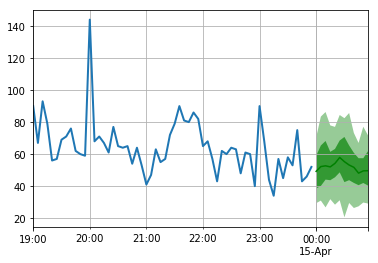

In [14]:
plot_forecast(predictor=deepar_predictor, test_data=test_data)

### Save the model
Both training and prediction networks can be saved using `estimator.serialize_prediction_net` and `estimator.serialize` respectively.

In [15]:
import os
os.makedirs('deepar', exist_ok=True)
deepar_predictor.serialize_prediction_net(pathlib.Path('deepar'))
deepar_predictor.serialize(pathlib.Path('deepar'))

### Evaluation
Below we are using `gluonts.evaluation.Evaluator` to create an aggregated evaluation metrics of the model we have trained. The `Evaluator` accepts predictions and calculates multiple evaluation metrics such as "MSE" and "Quantile Loss". The `Evaluator` returns both a dictionary and a pandas DataFrame. You can use the python dictionary, first output, or the pandas DataFrame, the second output, depending on what you would like to do. The dictionary item includes more values.

In [16]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
forecast_it, ts_it = make_evaluation_predictions(dataset=test_data, 
                                                        predictor=deepar_predictor, 
                                                        num_samples=100)
deepar_agg_metrics, item_metrics = Evaluator()(ts_it, 
                                                forecast_it, 
                                                 num_series=len(training_data))
deepar_agg_metrics

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


{'MSE': 262.71002197265625,
 'abs_error': 153.73080444335938,
 'abs_target_sum': 665.0,
 'abs_target_mean': 55.416666666666664,
 'seasonal_error': 12.780532802007231,
 'MASE': 1.0023760799915906,
 'sMAPE': 0.22737997059955495,
 'MSIS': 11.944006511566494,
 'QuantileLoss[0.1]': 44.290214538574226,
 'Coverage[0.1]': 0.08333333333333333,
 'QuantileLoss[0.2]': 77.76073760986328,
 'Coverage[0.2]': 0.25,
 'QuantileLoss[0.3]': 108.63641510009766,
 'Coverage[0.3]': 0.3333333333333333,
 'QuantileLoss[0.4]': 138.8849884033203,
 'Coverage[0.4]': 0.5,
 'QuantileLoss[0.5]': 153.73080444335938,
 'Coverage[0.5]': 0.5,
 'QuantileLoss[0.6]': 155.28981628417966,
 'Coverage[0.6]': 0.5833333333333334,
 'QuantileLoss[0.7]': 149.65671691894534,
 'Coverage[0.7]': 0.75,
 'QuantileLoss[0.8]': 140.64255981445314,
 'Coverage[0.8]': 0.75,
 'QuantileLoss[0.9]': 105.15487594604491,
 'Coverage[0.9]': 0.75,
 'RMSE': 16.208331868907923,
 'NRMSE': 0.2924811765817971,
 'ND': 0.2311741420200893,
 'wQuantileLoss[0.1]': 0.

In [17]:
item_metrics.T

,0
item_id,NaN
MSE,262.710022
abs_error,153.730804
abs_target_sum,665.000000
abs_target_mean,55.416667
seasonal_error,12.780533
MASE,1.002376
sMAPE,0.227380
MSIS,11.944007
QuantileLoss[0.1],44.290215


### Comparison 
We now use another estimator, `SimpleFeedForwardEstimator`, to make the same forecast. This model is using a simple MLP or a feed forward network to reach the same goal. At the end we shall compare the results of the models.

In [ ]:
mlp_estimator = SimpleFeedForwardEstimator(freq="5min", 
                                           prediction_length=12, 
                                           trainer=Trainer(epochs=EPOCHS))
mlp_predictor = mlp_estimator.train(training_data=training_data)

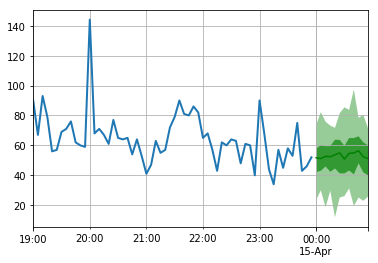

In [19]:
plot_forecast(predictor=mlp_predictor, test_data=test_data)


The code snippet below, is using the same mechanism we have used before for evaluation, except the function accepts data and a list of predictors as well as a textual name for the predictors to use as column name in the pandas DataFrame output. It then loops over predictors, performs evaluation, converts the evaluation dictionary into a pandas DataFrame, and appends the output of evaluation to a dataframe as as a new column.

In [21]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
def evaluat_models_from_dict(data, predictors, predictor_names, num_samples=100):
    '''
    Comparing results of multiple models.
    Parameters:
        data: the dataset on which we are performing the evaluation.
        predictors: A list of predictor objects
        predictor_names: A list of textual names for the predictors that have an ordered one-to-one
                         relationship with the predictors.
        num_samples (default=100): what sample size from the evaluation dataset.
    Output: pandas dataframe to an evaluation column per predictor.
    '''
    df = pd.DataFrame()
    for (predictor, predictor_name) in zip(predictors, predictor_names):
        forecast_it, ts_it = make_evaluation_predictions(data, 
                                                        predictor=predictor, 
                                                        num_samples=num_samples)
        deepar_agg_metrics, item_metrics = Evaluator()(ts_it, 
                                                       forecast_it, 
                                                       num_series=len(data))
               
        evaluation = pd.DataFrame.from_dict(deepar_agg_metrics, orient='index', columns=[predictor_name])
        if df.empty:
            df = evaluation.copy()
        else:
            df.insert(loc=len(df.columns), column=predictor_name, value=evaluation.values)
    return df
evaluat_models_from_dict(data=test_data, 
               predictors=[deepar_predictor, mlp_predictor, naive_predictor], 
               predictor_names = ['deepar', 'mlp', 'naive predictor'])

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 79.58it/s]


,deepar,mlp,naive predictor
MSE,235.164062,249.156067,463.083333
abs_error,149.166855,128.750061,197.000000
abs_target_sum,665.000000,665.000000,665.000000
abs_target_mean,55.416667,55.416667,55.416667
seasonal_error,12.780533,12.780533,12.780533
MASE,0.972618,0.839493,1.284506
sMAPE,0.220868,0.189198,0.311802
MSIS,9.449646,11.743544,51.380226
QuantileLoss[0.1],47.852766,65.737691,49.000000
Coverage[0.1],0.000000,0.083333,0.083333


### Accessing weights and model parameters
You can use an estimator and call `train_model` in order to get access to the netword structure and parameters. `train_model` is an instance of `DeepARTrainingNetwork`, which in turn is derived from `DeepARNetwork`, which itself is derived from `mxnet.gluon.block.HybridBlock`.
The following code demonstrates how to lookup the objects lineage.

In [22]:
gluonts.model.deepar._network.DeepARTrainingNetwork.__bases__[0].__bases__[0]

mxnet.gluon.block.HybridBlock

In [ ]:
train_model = deepar_estimator.train_model(training_data)

We can now call `DeepARTrainingNetwork.collect_params()`, which returns a `mxnet.gluon.parameter.ParameterDict` object. for more information how to query `ParameterDict`, plese refer to [mxnet documentation.](https://mxnet.incubator.apache.org/api/python/gluon/gluon.html#mxnet.gluon.ParameterDict)

In [24]:
deepar_predictor.prediction_net.collect_params() 

deepartrainingnetwork1_ (
  Parameter deepartrainingnetwork1_None_distr_mu_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_None_distr_mu_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_None_distr_sigma_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_None_distr_sigma_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_None_distr_nu_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_None_distr_nu_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_lstm0_i2h_weight (shape=(160, 43), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_lstm0_h2h_weight (shape=(160, 40), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_lstm0_i2h_bias (shape=(160,), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork1_lstm0_h2h_bias (shape=(160,), dt